# Exploratory data analysis

## 1 - Basic configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import statsmodels.api as sm

In [17]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
plt.style.use("fivethirtyeight")

## 2 - Data acquisition

In [4]:
df_sinasc = pd.read_parquet("./data/sinasc_br_19_20.parquet")

In [5]:
df_sinasc.replace({"nan":np.nan}, inplace=True)

In [6]:
categorical_variables = df_sinasc.select_dtypes("object").columns.tolist() + ["adolescent_mom", "premature"]
numerical_variables = df_sinasc.drop(columns=categorical_variables).columns.tolist()

## 3 - Data visualization

### 3.1 - Univariate analysis

#### 3.1.1 - Categorical data

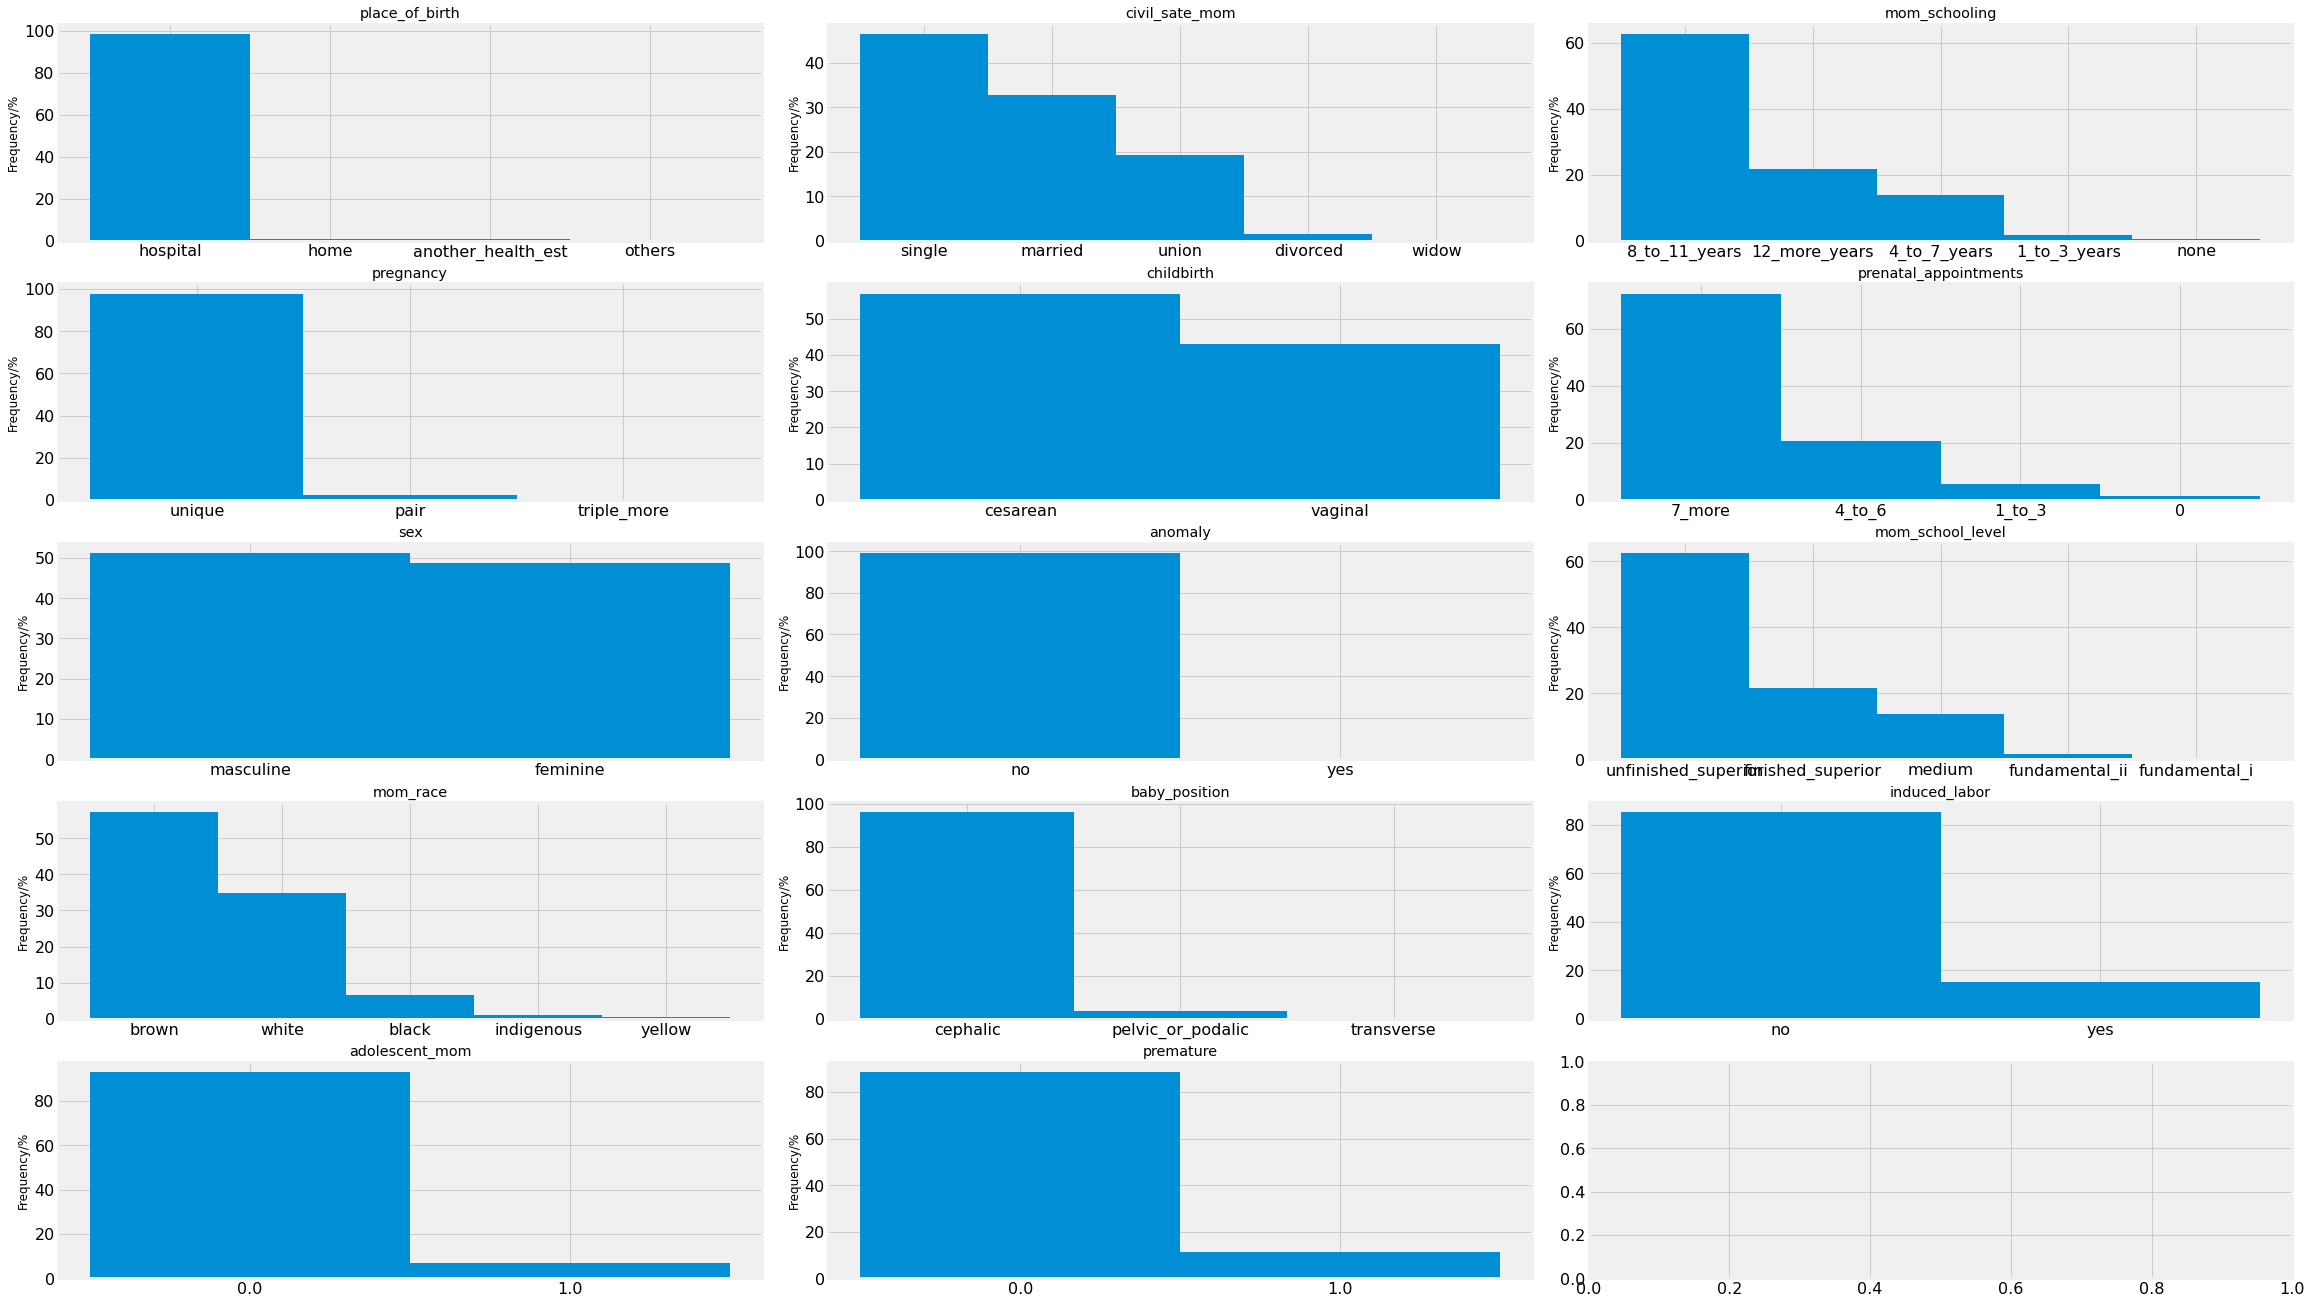

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(32, 18), layout="constrained")

count_plot = 0

for variable in categorical_variables:
    aux = (
        df_sinasc[variable]
        .value_counts(normalize=True)
        .reset_index()
        .rename(columns={"index":"categoria"})
    )
    ax[count_plot//3][count_plot%3].bar(
        aux.index,
        100*aux[variable],
        width=1
    )
    ax[count_plot//3][count_plot%3].set_xticks(aux.index)
    ax[count_plot//3][count_plot%3].set_xticklabels(aux.categoria)
    ax[count_plot//3][count_plot%3].set_title(variable)
    ax[count_plot//3][count_plot%3].set_ylabel("Frequency/%")
    count_plot += 1

#### 3.1.2 - Numerical data

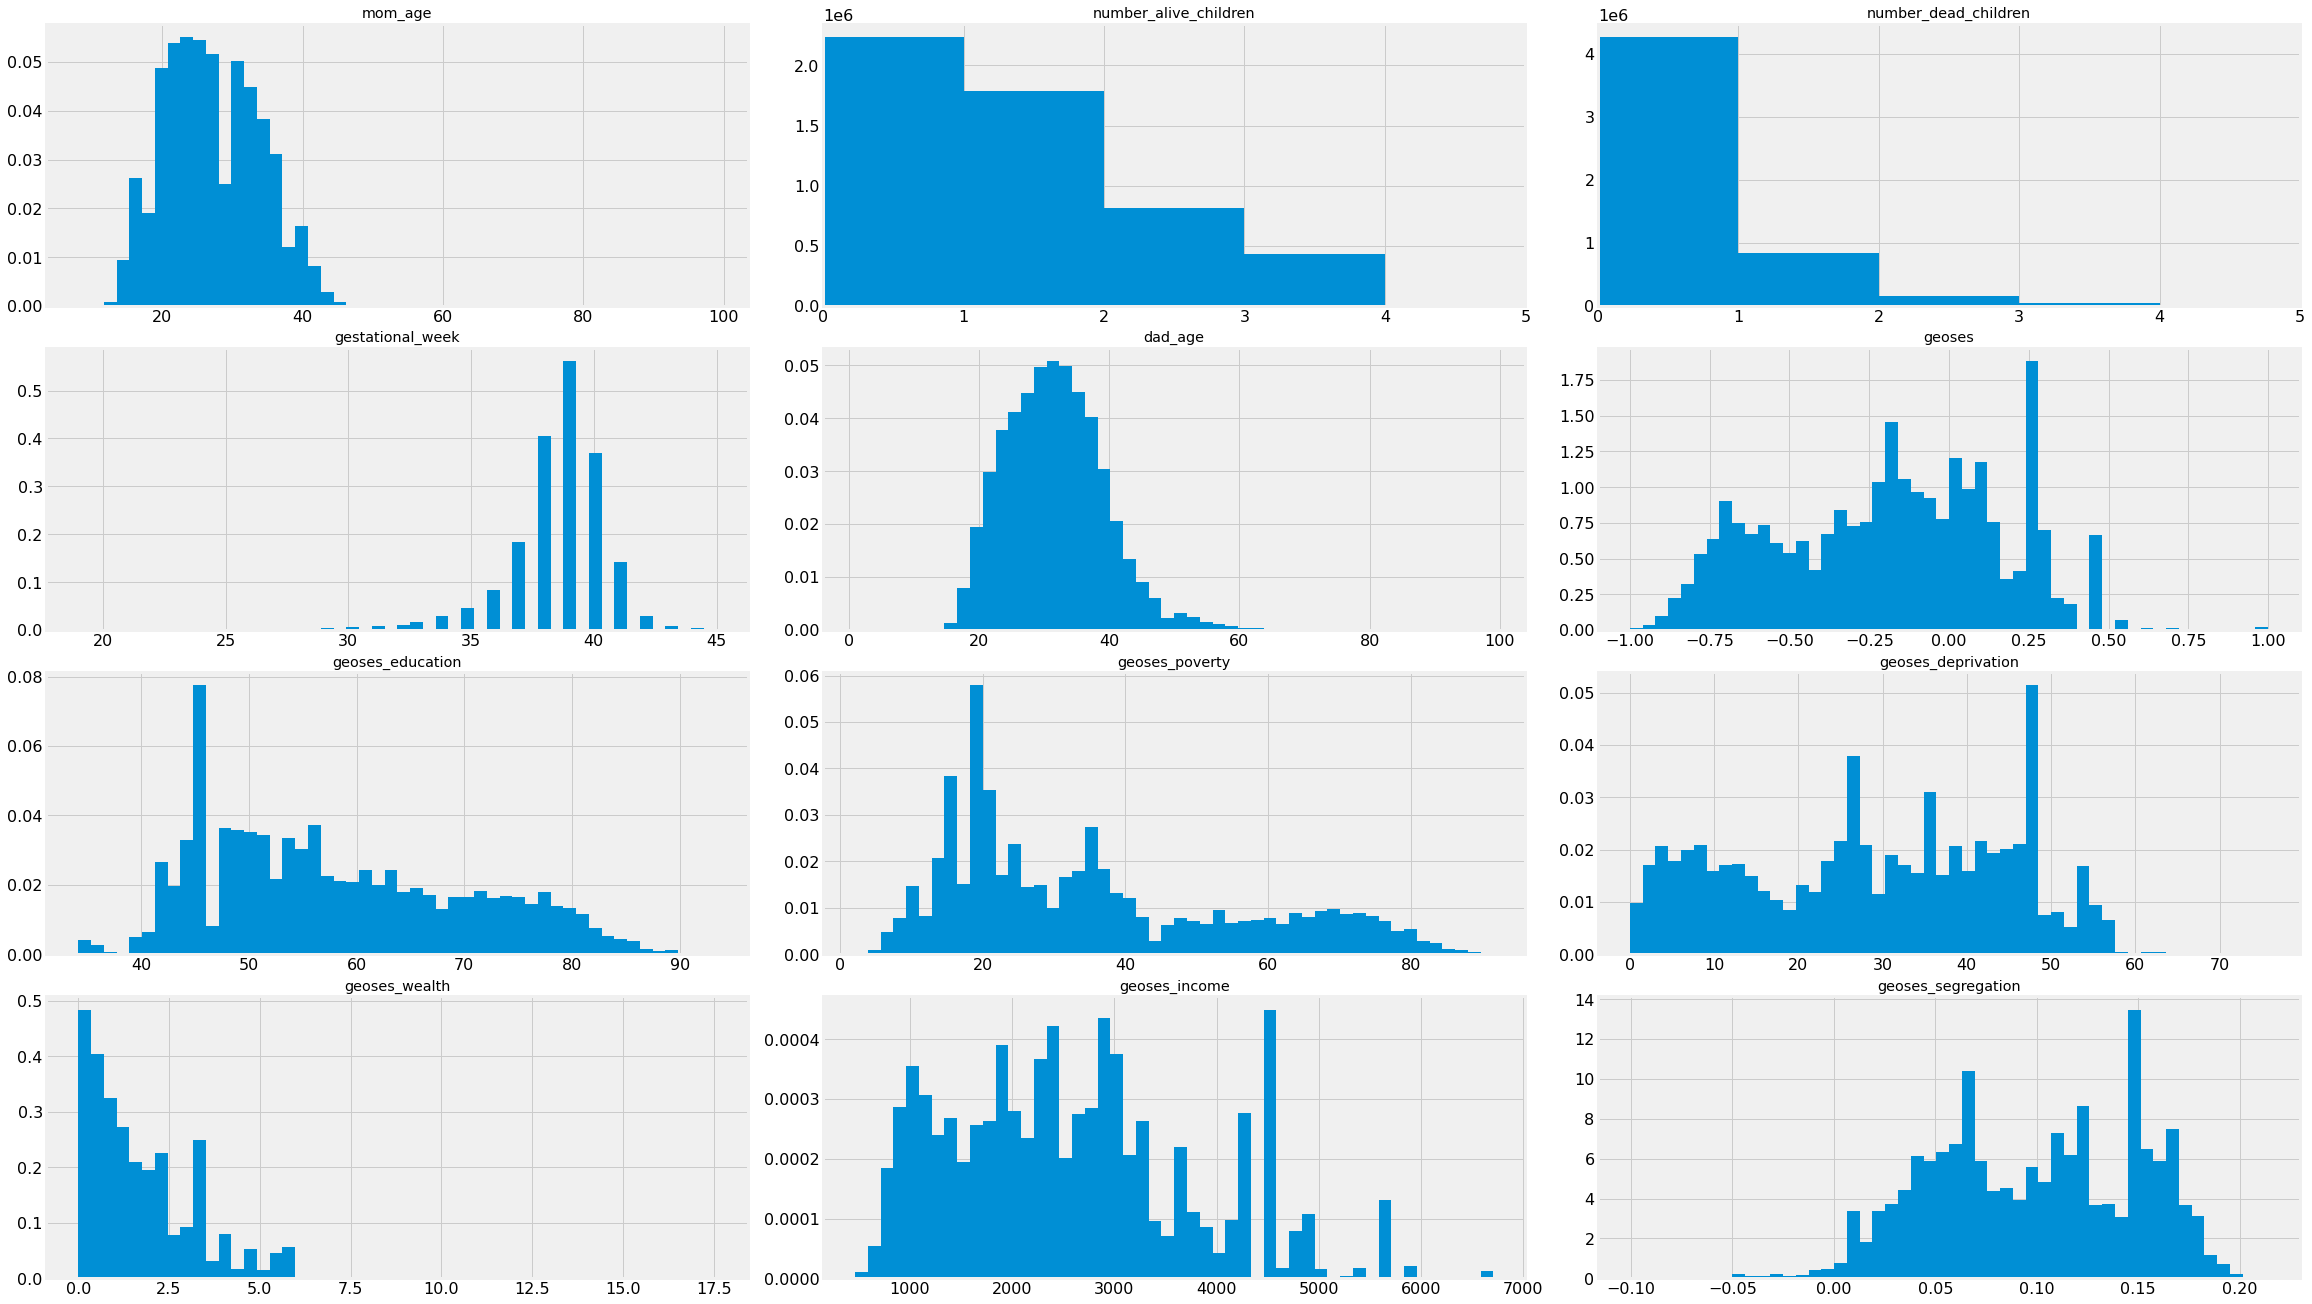

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(32, 18), layout="constrained")

count_plot = 0

for variable in numerical_variables:
    if variable in ["number_alive_children", "number_dead_children"]:
        ax[count_plot//3][count_plot%3].hist(
            df_sinasc[variable],
            bins=np.arange(0,5)
        )
        ax[count_plot//3][count_plot%3].set_title(variable)
        ax[count_plot//3][count_plot%3].set_xlim(0, 5)
    else:
        ax[count_plot//3][count_plot%3].hist(
            df_sinasc[variable],
            bins=50,
            density=True
        )
        ax[count_plot//3][count_plot%3].set_title(variable)
    count_plot += 1

### 3.2 - Bivariate analysis

#### 3.2.1 - Categorical data vs target

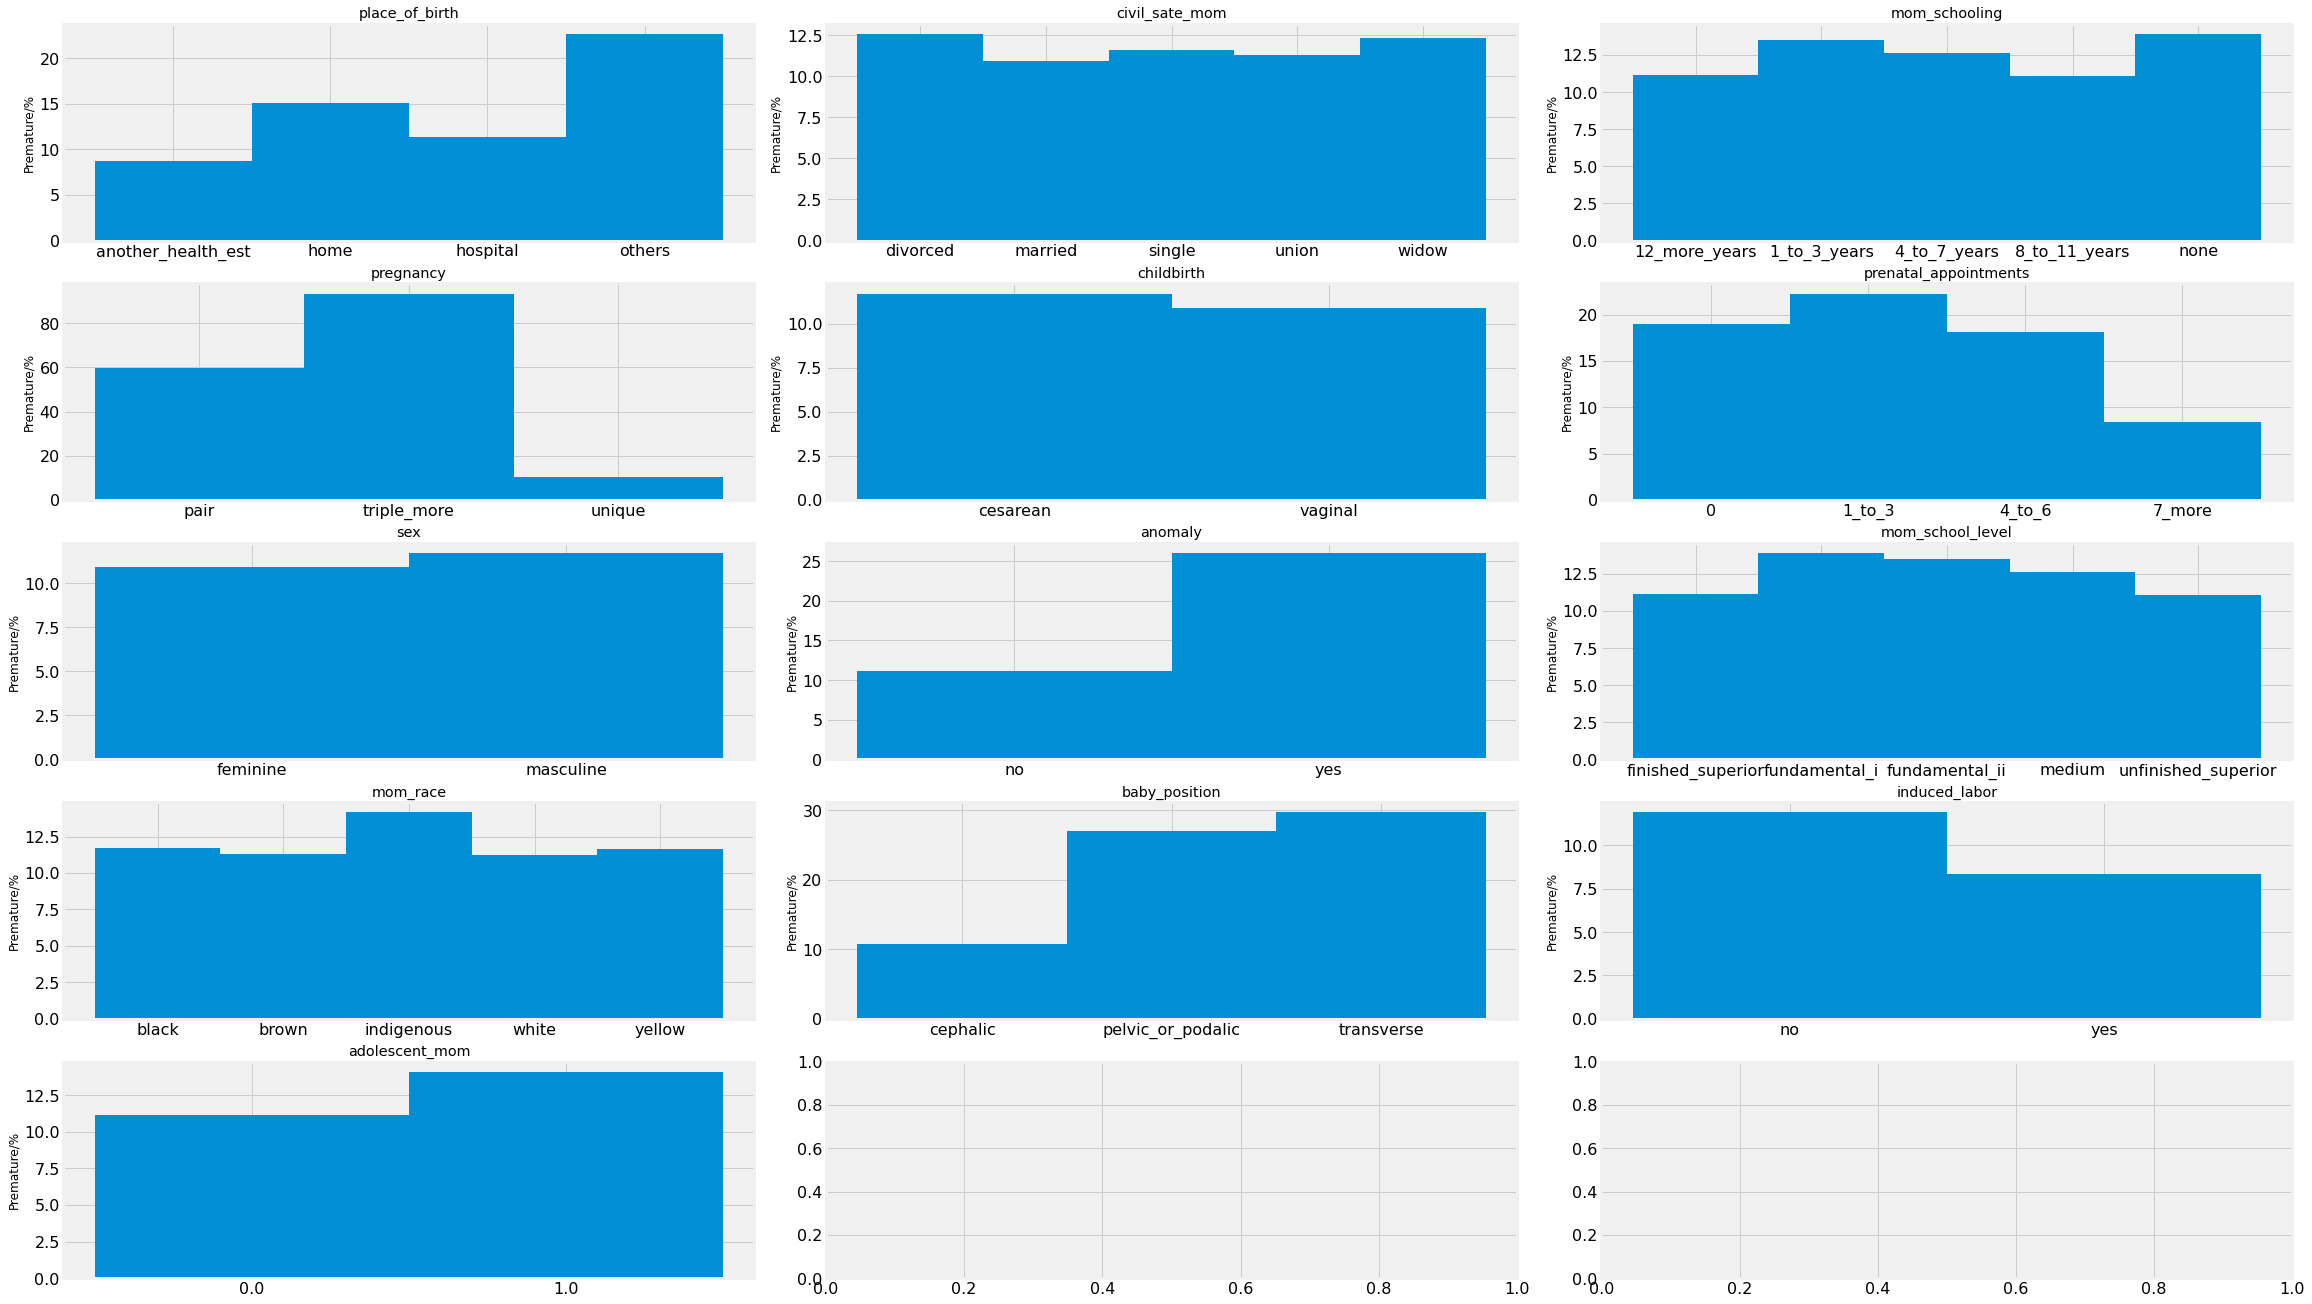

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(32, 18), layout="constrained")

count_plot = 0

for variable in categorical_variables:
    if variable != "premature":
        aux = (
            df_sinasc
            .groupby(variable)
            .agg(
                premature_frequency = ("premature", lambda x: x.mean()*100)
            )
            .reset_index()
        )
        ax[count_plot//3][count_plot%3].bar(
            aux.index,
            aux["premature_frequency"],
            width=1
        )
        ax[count_plot//3][count_plot%3].set_xticks(aux.index)
        ax[count_plot//3][count_plot%3].set_xticklabels(aux[variable])
        ax[count_plot//3][count_plot%3].set_title(variable)
        ax[count_plot//3][count_plot%3].set_ylabel("Premature/%")
        count_plot += 1

#### 3.2.2 - Numerical data correlation

<Axes: >

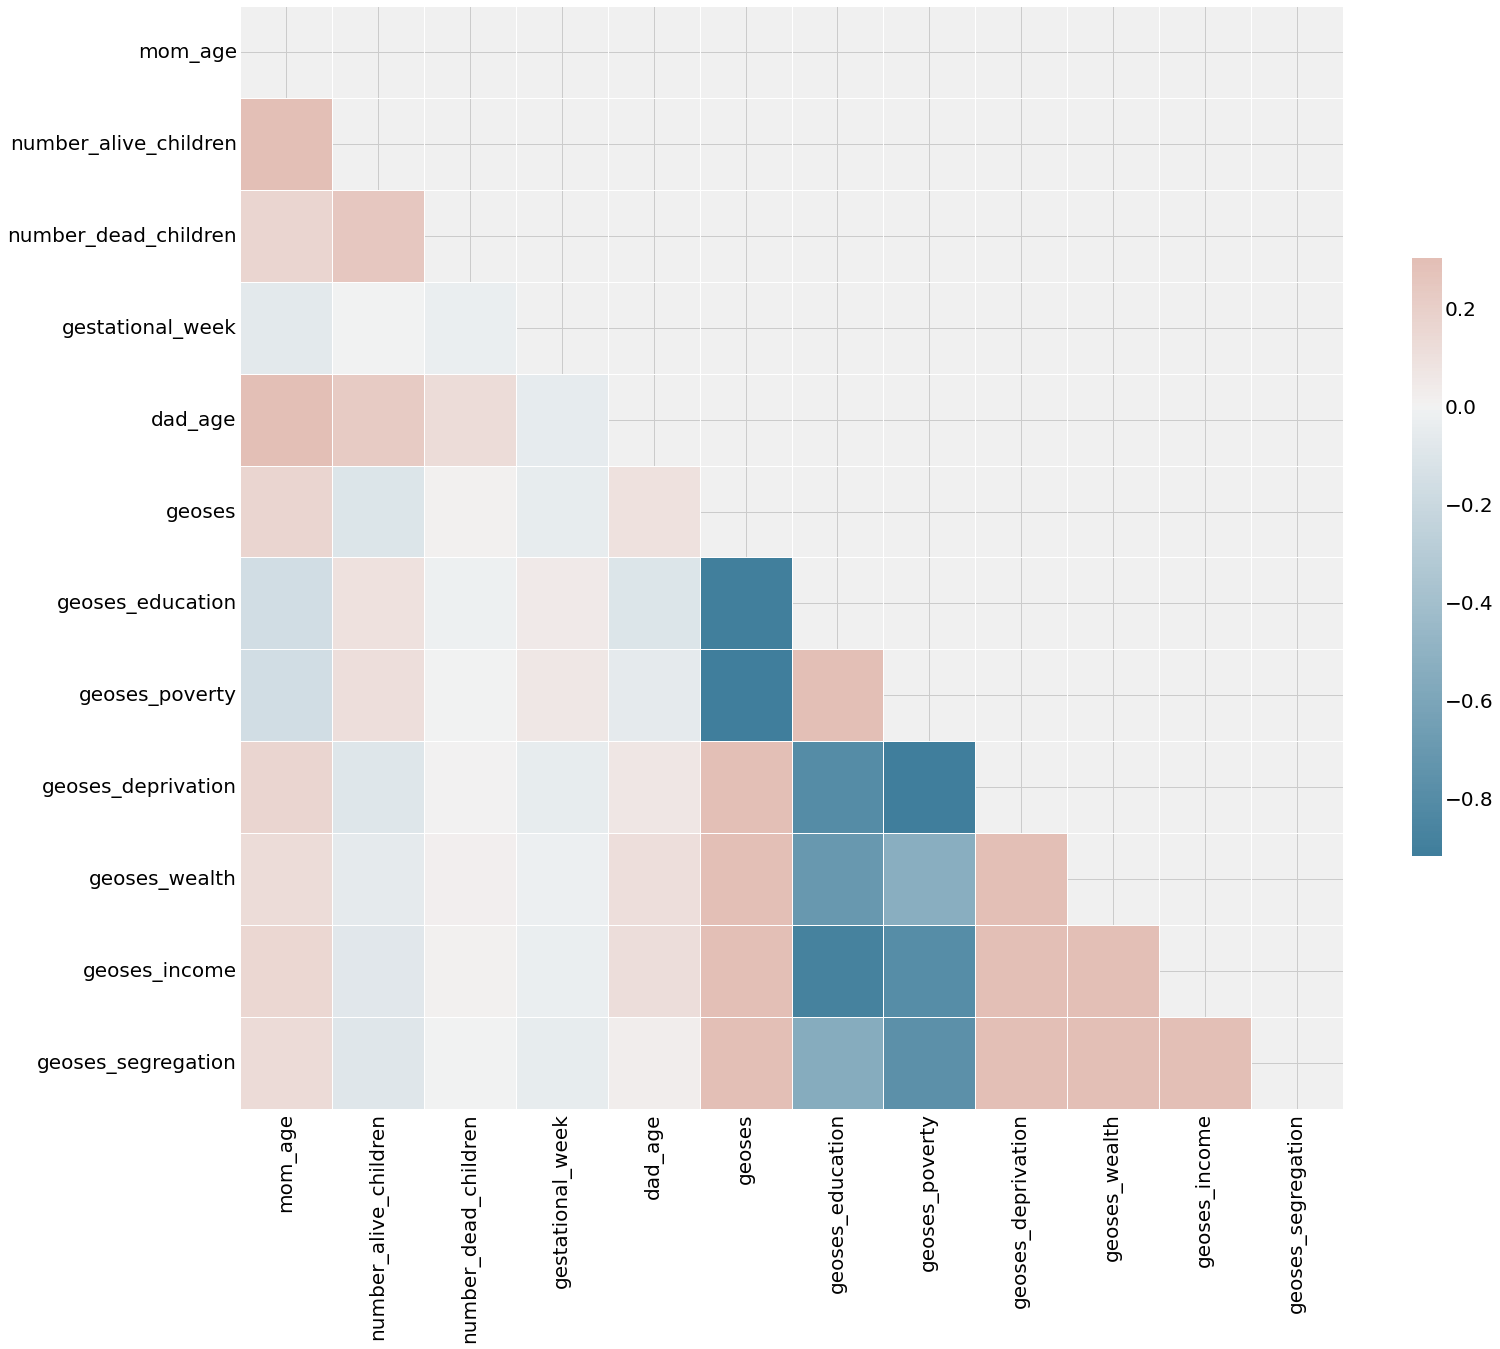

In [21]:
df_corr = df_sinasc[numerical_variables].corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
f, ax = plt.subplots(figsize=(22, 22))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### 3.2.3 - Numerical data vs target

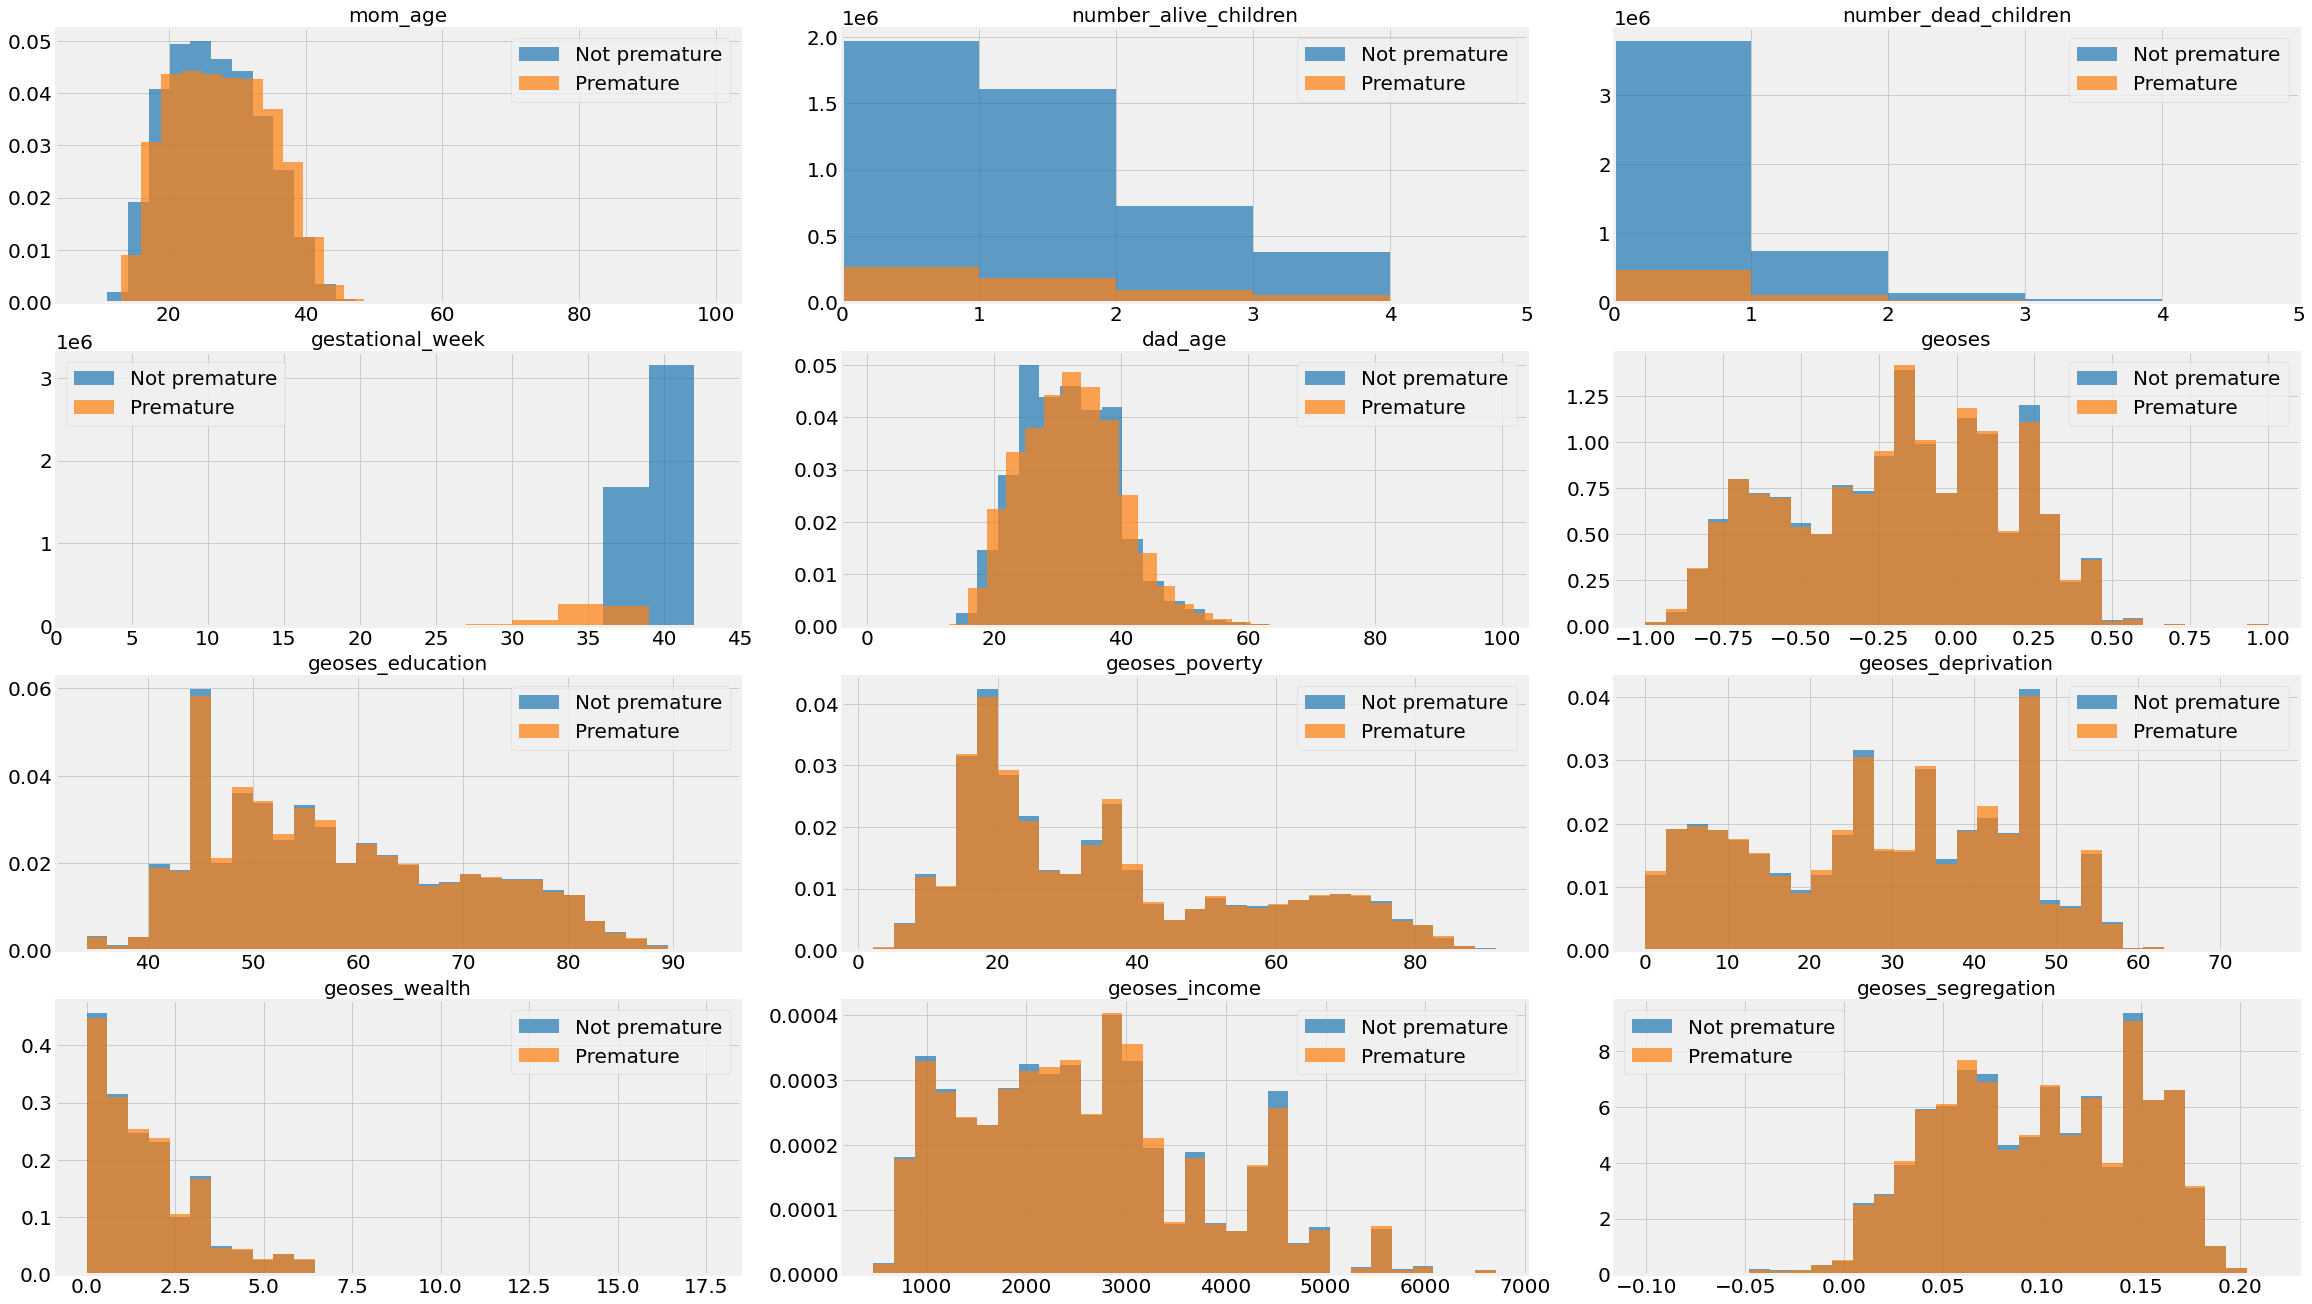

In [18]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(32, 18), layout="constrained")

count_plot = 0

for variable in numerical_variables:
    aux_premature = df_sinasc.query("premature == 1")[variable]
    aux_not_premature = df_sinasc.query("premature == 0")[variable]
    if variable in ["number_alive_children", "number_dead_children"]:
        ax[count_plot//3][count_plot%3].hist(
            aux_not_premature,
            bins=np.arange(0,5),
            label="Not premature",
            color=plt.cm.tab10.colors[0],
            alpha=0.7
        )
        ax[count_plot//3][count_plot%3].hist(
            aux_premature,
            bins=np.arange(0,5),
            label="Premature",
            color=plt.cm.tab10.colors[1],
            alpha=0.7
        )
        
        ax[count_plot//3][count_plot%3].set_xlim(0, 5)
    elif variable == "gestational_week":
        ax[count_plot//3][count_plot%3].hist(
            aux_not_premature,
            bins=np.arange(0,45, 3),
            label="Not premature",
            color=plt.cm.tab10.colors[0],
            alpha=0.7
        )
        ax[count_plot//3][count_plot%3].hist(
            aux_premature,
            bins=np.arange(0,45, 3),
            label="Premature",
            color=plt.cm.tab10.colors[1],
            alpha=0.7
        )
        
        ax[count_plot//3][count_plot%3].set_xlim(0, 45)
    else:
        ax[count_plot//3][count_plot%3].hist(
            aux_not_premature,
            bins=30,
            label="Not premature",
            color=plt.cm.tab10.colors[0],
            density=True,
            alpha=0.7
        )
        ax[count_plot//3][count_plot%3].hist(
            aux_premature,
            bins=30,
            label="Premature",
            color=plt.cm.tab10.colors[1],
            density=True,
            alpha=0.7
        )
    ax[count_plot//3][count_plot%3].set_title(variable)
    ax[count_plot//3][count_plot%3].legend()
    count_plot += 1

### 3.3 - Missing analysis

In [19]:
df_premature_vs_missing = (
    df_sinasc
    .assign(
        missing = lambda df: (
            df
            .isna()
            .any(axis=1)
        )
    )
    .groupby("missing")
    .agg(
        premature_frequency = ("premature", lambda x: x.mean()*100)
    )
    .reset_index()
)

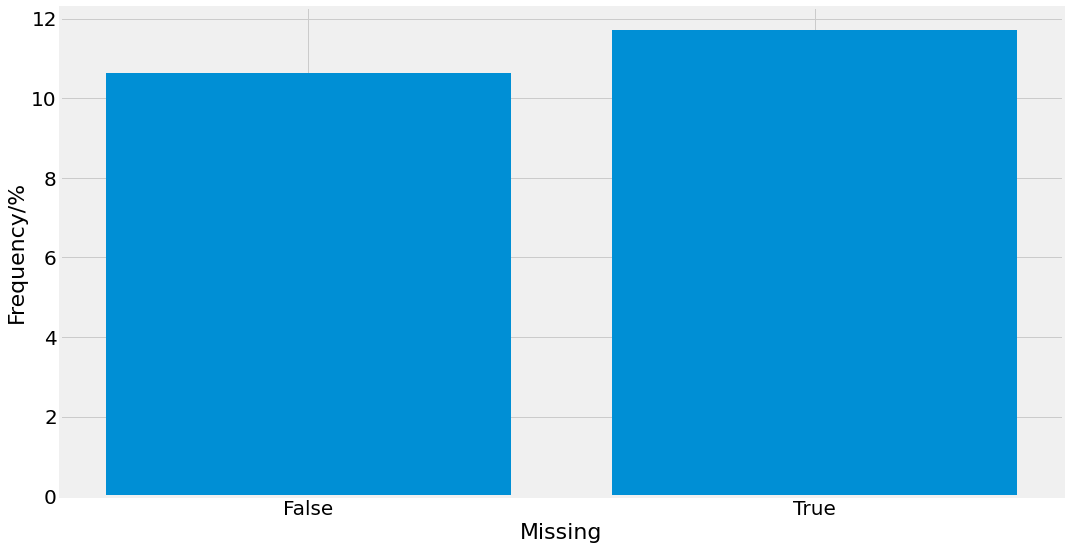

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.bar(
    df_premature_vs_missing.index,
    df_premature_vs_missing["premature_frequency"]
)
ax.set_xticks(df_premature_vs_missing.index)
ax.set_xticklabels(df_premature_vs_missing["missing"])
ax.set_ylabel("Frequency/%")
ax.set_xlabel("Missing");